In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

head(raw_data)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 7999 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): aluminium, ammonia, arsenic, barium, cadmium, chloramine, chromium...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


In [3]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

In [4]:
water_wrangled <- water_train |>
                    pivot_longer(cols = arsenic:nitrites, names_to = "contaminant", values_to = "level")

water_means <- water_wrangled |> 
                     na.omit() |>
                     group_by(contaminant)|>
                     summarize(average_value = mean(level))

water_means

# Manipulating data to get number of observations for each class
water_train_table <- water_train |> 
                     na.omit() |>
                     group_by(is_safe)|>
                     summarize(count = n())

water_train_table


contaminant,average_value
<chr>,<dbl>
arsenic,0.16028519
bacteria,0.32169113
lead,0.09915294
nitrates,9.85693629
nitrites,1.33340560
viruses,0.33060107


is_safe,count
<fct>,<int>
not safe,5313
safe,683


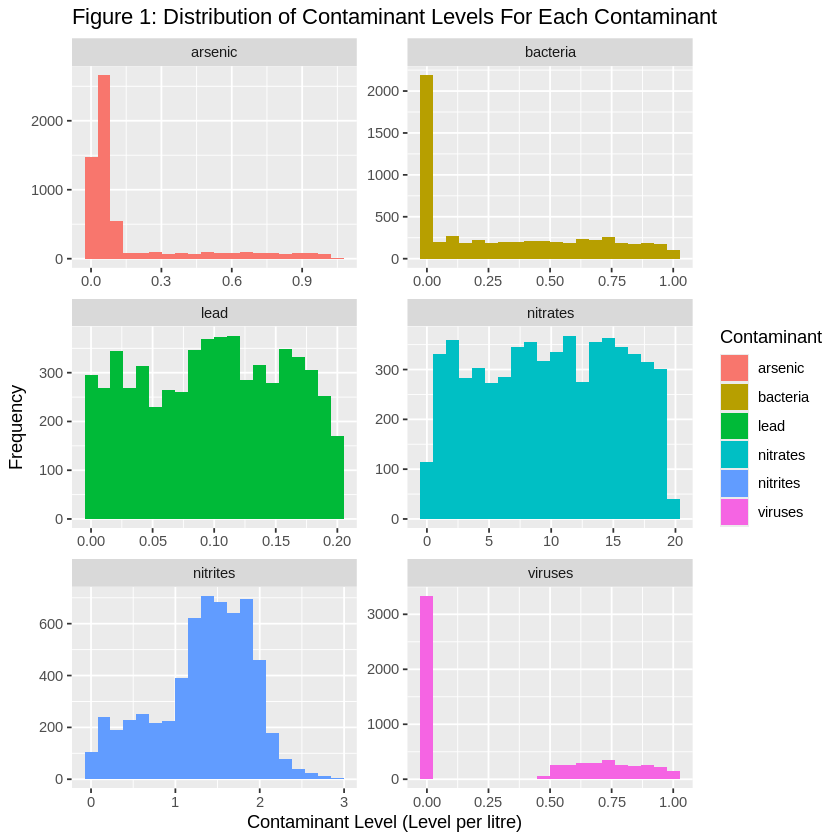

In [5]:
water_train_plot <- water_wrangled |>
                    ggplot(aes(x=level, fill = contaminant)) +
                    geom_histogram(bins = 20) +
                    facet_wrap(vars(contaminant), scales = "free", nrow = 3) +
                    labs(x=" Contaminant Level (Level per litre)", y="Frequency", fill="Contaminant") +
                    ggtitle("Figure 1: Distribution of Contaminant Levels For Each Contaminant")

water_train_plot

In [6]:
#step 1: create a recipe for the training data

water_recipe <- recipe(is_safe ~ arsenic + bacteria + viruses + lead + nitrates + nitrites, data = water_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())
water_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [7]:
#step 2: create a multiple training datasets to perform cross validation

water_vfold <- vfold_cv(water_train, v = 5, strata = is_safe)

In [8]:
#step 3: create a classification model that allows us to tune the number of neighbors

water_knn <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

In [11]:
#step 4: create a workflow that combines the recipe, model specification and that performs the vfold cross validation
grid_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 5))


knn_workflow <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn) |>
    tune_grid(resamples = water_vfold, grid = grid_vals)

In [12]:
#step 5: collect the metrics to allow us to determine which k value is most resonable

knn_results <- knn_workflow |>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8025383,5,0.003504913,Preprocessor1_Model01
1,roc_auc,binary,0.5172897,5,0.004767901,Preprocessor1_Model01
6,accuracy,binary,0.8747498,5,0.001570281,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,roc_auc,binary,0.7027089,5,0.0076696461,Preprocessor1_Model10
51,accuracy,binary,0.8852575,5,0.0009130513,Preprocessor1_Model11
51,roc_auc,binary,0.7025331,5,0.0077551347,Preprocessor1_Model11


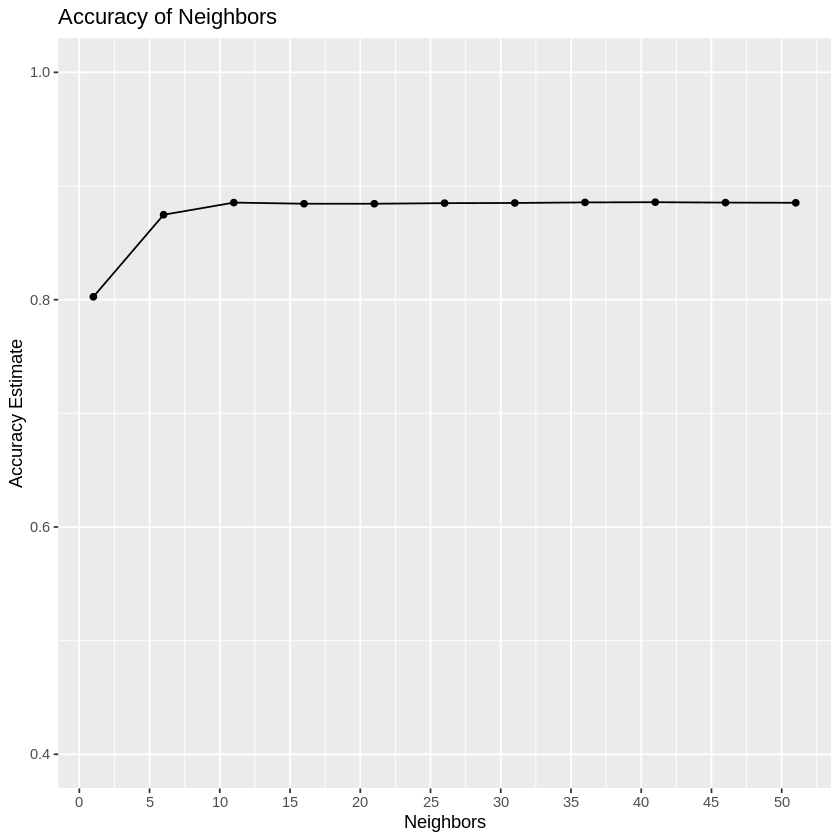

In [16]:
#this plot depicts the accuracy of the model at each given value of n nearest neighbors
water_accuracy <- knn_results |>
    filter(.metric == 'accuracy')

recall_plot <- ggplot(water_recall, aes(x = neighbors, y = mean))+ 
                      geom_point()+
                      geom_line()+
                      labs(x = 'Neighbors', y = 'Accuracy Estimate')+
                      ggtitle('Accuracy of Neighbors')+
                    scale_x_continuous(breaks = seq(0, 51, by = 5))+
                    scale_y_continuous(limits = c(0.4, 1.0))
                        
recall_plot

In [18]:
#determine which k value gives the most accurate model:

best_3_accuracy <- water_accuracy|>
    arrange(desc(mean))|>
    head(3)|>
    pull(neighbors)

best_3_accuracy

[1] 41 36 46

This plot indicates that the most accurate model to predict whether the water is safe or not is a model with either 41, 36, or 46 nearest neighbors. We will be performing three seperate tests on three models with these values of n, to determine which is most applicable to our problem.

In [19]:
#model 1 (36 nearest neighbors):

water_knn_36 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 36) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_36 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_36) |>
    fit(data = water_train)

test_pred_36 <- predict(knn_workflow_36, water_test)|>
    bind_cols(water_test)
test_pred_36

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.04,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.01,0.13,0.007,0.021,18.60,1.78,not safe
not safe,0.04,0.16,0.005,0.197,13.65,1.81,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not safe,0.07,0,0,0.016,15.15,1,not safe
not safe,0.00,0,0,0.182,15.92,1,safe
not safe,0.01,0,0,0.182,15.92,1,safe


In [20]:
#model 2 (14 nearest neighbors):

water_knn_41 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 41) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_41 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_41) |>
    fit(data = water_train)

test_pred_41 <- predict(knn_workflow_41, water_test)|>
    bind_cols(water_test)
test_pred_41

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.04,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.01,0.13,0.007,0.021,18.60,1.78,not safe
not safe,0.04,0.16,0.005,0.197,13.65,1.81,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not safe,0.07,0,0,0.016,15.15,1,not safe
not safe,0.00,0,0,0.182,15.92,1,safe
not safe,0.01,0,0,0.182,15.92,1,safe


In [21]:
#model 3 (15 nearest neighbors):

water_knn_46 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 46) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_46 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_46) |>
    fit(data = water_train)

test_pred_46 <- predict(knn_workflow_46, water_test)|>
    bind_cols(water_test)
test_pred_46

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.04,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.01,0.13,0.007,0.021,18.60,1.78,not safe
not safe,0.04,0.16,0.005,0.197,13.65,1.81,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not safe,0.07,0,0,0.016,15.15,1,not safe
not safe,0.00,0,0,0.182,15.92,1,safe
not safe,0.01,0,0,0.182,15.92,1,safe


Now, we have to analyze the metrics of our three models.

In [22]:
model_1_accuracy <- test_pred_36|>
    metrics(truth = is_safe, estimate = .pred_class)


model_2_accuracy <- test_pred_41|>
    metrics(truth = is_safe, estimate = .pred_class)


model_3_accuracy <- test_pred_46|>
    metrics(truth = is_safe, estimate = .pred_class)

model_1_accuracy
model_2_accuracy
model_3_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8850000000
kap,binary,-0.0009966445


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8855
kap,binary,0.0000


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8855
kap,binary,0.0000


In [23]:
#now we can find the precision:

model_1_precision <- test_pred_36|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_2_precision <- test_pred_41|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_3_precision <- test_pred_46|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')


model_1_precision
model_2_precision
model_3_precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8854427


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8855


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8855


In [25]:
#now we find the recall for our three models

model_1_recall <- test_pred_36|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_2_recall <- test_pred_41|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_3_recall <- test_pred_46|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')


model_1_recall
model_2_recall
model_3_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9994353


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


What we can see is that model 2 or 3 will likely offer us the best predictions in our case, as they predict with 88.55% accuracy and 88.55% precision.